In [361]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [362]:
df=pd.read_csv('./HDFC.csv',index_col='Date',parse_dates=True)

Data Pre processing


In [363]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HDFC,EQ,271.75,293.50,293.50,293.50,293.50,293.50,293.50,22744,6.675364e+11,NaN,NaN,NaN
2000-01-04,HDFC,EQ,293.50,317.00,317.00,297.00,304.00,304.05,303.62,255251,7.749972e+12,NaN,NaN,NaN
2000-01-05,HDFC,EQ,304.05,290.00,303.90,285.00,295.00,292.80,294.53,269087,7.925368e+12,NaN,NaN,NaN
2000-01-06,HDFC,EQ,292.80,301.00,314.00,295.00,296.00,296.45,300.14,305916,9.181669e+12,NaN,NaN,NaN
2000-01-07,HDFC,EQ,296.45,290.00,296.35,281.00,287.10,286.55,288.80,197039,5.690480e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HDFC,EQ,2497.35,2500.00,2534.10,2483.20,2502.00,2509.80,2508.07,3916088,9.821805e+14,121028.0,2440395.0,0.6232
2021-04-27,HDFC,EQ,2509.80,2494.15,2526.80,2486.25,2514.00,2518.40,2509.18,2040799,5.120730e+14,102250.0,1040749.0,0.5100
2021-04-28,HDFC,EQ,2518.40,2516.10,2609.00,2508.30,2575.00,2577.00,2574.21,3407461,8.771527e+14,117425.0,1815110.0,0.5327


In [364]:
df['Date']=df.index

In [365]:
start_date='2016-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [366]:
df=df.loc[mask]

In [367]:
df=df.loc[mask]

In [368]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [369]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [370]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [371]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [372]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (1187, 50) Y.shape (1187,)


In [373]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

ANN

In [374]:
i=Input(shape=(T,))
x=Dense(400,activation='relu')(i)
x=Dense(100,activation='relu')(x)
x=Dense(50,activation='relu')(x)
x=Dense(1,activation='relu')(x)
model_ann=Model(i,x)
model_ann.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 50)]              0         
                                                                 
 dense_66 (Dense)            (None, 400)               20400     
                                                                 
 dense_67 (Dense)            (None, 100)               40100     
                                                                 
 dense_68 (Dense)            (None, 50)                5050      
                                                                 
 dense_69 (Dense)            (None, 1)                 51        
                                                                 
Total params: 65,601
Trainable params: 65,601
Non-trainable params: 0
_________________________________________________________________


In [375]:
model_ann.compile(
    loss='mse',
    optimizer='adamax',
    metrics='mae'
)

In [376]:
r=model_ann.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
26/26 [==============================] - 1s 8ms/step - loss: 544.1213 - mae: 17.6115 - val_loss: 2520.0486 - val_mae: 34.5720
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 526.7050 - mae: 17.1754 - val_loss: 2586.2068 - val_mae: 34.9234
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 507.4780 - mae: 16.7586 - val_loss: 2600.6433 - val_mae: 35.0420
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 493.9756 - mae: 16.3945 - val_loss: 2671.5276 - val_mae: 35.6799
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 479.5136 - mae: 16.0955 - val_loss: 2654.8110 - val_mae: 35.6388
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 468.7465 - mae: 15.8128 - val_loss: 2652.1360 - val_mae: 35.6754
Epoch 7/100
26/26 [==============================] - 0s 6ms/step - loss: 459.7819 - mae: 15.5776 - val_loss: 2677.5190 - val_mae: 35.9083
Epoch 8/100
26/26 [===============

CNN

In [377]:
i=Input(shape=(T,1))
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(1)(x)
model_cnn=Model(i,x)
model_cnn.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 48, 25)            100       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 24, 25)           0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d_18 (Gl  (None, 50)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_70 (Dense)            (None, 1)                 51 

In [378]:
model_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [379]:
r=model_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
26/26 [==============================] - 1s 9ms/step - loss: 617.4607 - mae: 18.8549 - mse: 617.4607 - val_loss: 2626.2893 - val_mae: 35.6521 - val_mse: 2626.2893
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 544.8173 - mae: 17.7788 - mse: 544.8173 - val_loss: 2597.5232 - val_mae: 35.3077 - val_mse: 2597.5232
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 540.2739 - mae: 17.6762 - mse: 540.2739 - val_loss: 2607.6677 - val_mae: 35.3402 - val_mse: 2607.6677
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 535.2455 - mae: 17.5964 - mse: 535.2455 - val_loss: 2612.2822 - val_mae: 35.3109 - val_mse: 2612.2822
Epoch 5/100
26/26 [==============================] - 0s 6ms/step - loss: 533.5650 - mae: 17.5330 - mse: 533.5650 - val_loss: 2605.6565 - val_mae: 35.2487 - val_mse: 2605.6565
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 533.4017 - mae: 17.5648 - mse: 533.4017 - val_loss: 

LSTM

In [380]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm=Model(i,x)
model_lstm.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 lstm_12 (LSTM)              (None, 50, 200)           161600    
                                                                 
 lstm_13 (LSTM)              (None, 50, 200)           320800    
                                                                 
 global_max_pooling1d_19 (Gl  (None, 200)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_71 (Dense)            (None, 100)               20100     
                                                                 
 dense_72 (Dense)            (None, 50)                5050      
                                                          

In [381]:
check_point_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [382]:
model_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [383]:
r=model_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm]
)

Epoch 1/100
26/26 [==============================] - 9s 216ms/step - loss: 543.4900 - mae: 17.6485 - mse: 543.4900 - val_loss: 2515.5520 - val_mae: 34.4847 - val_mse: 2515.5520
Epoch 2/100
26/26 [==============================] - 5s 180ms/step - loss: 542.3990 - mae: 17.6196 - mse: 542.3990 - val_loss: 2515.2268 - val_mae: 34.4653 - val_mse: 2515.2268
Epoch 3/100
26/26 [==============================] - 5s 186ms/step - loss: 541.5025 - mae: 17.6198 - mse: 541.5025 - val_loss: 2514.8057 - val_mae: 34.4609 - val_mse: 2514.8057
Epoch 4/100
26/26 [==============================] - 5s 193ms/step - loss: 540.6500 - mae: 17.6150 - mse: 540.6500 - val_loss: 2514.5542 - val_mae: 34.4431 - val_mse: 2514.5542
Epoch 5/100
26/26 [==============================] - 5s 186ms/step - loss: 540.7469 - mae: 17.6215 - mse: 540.7469 - val_loss: 2513.2166 - val_mae: 34.4417 - val_mse: 2513.2166
Epoch 6/100
26/26 [==============================] - 5s 183ms/step - loss: 541.0989 - mae: 17.6385 - mse: 541.0989 

GRU

In [384]:
i=Input(shape=(T,1))
x=GRU(200,return_sequences=True)(i)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_gru=Model(i,x)
model_gru.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fe988352310>>

In [385]:
check_point_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [386]:
model_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [387]:
r=model_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_gru]
)

Epoch 1/100
26/26 [==============================] - 8s 200ms/step - loss: 545.3457 - mae: 17.6494 - mse: 545.3457 - val_loss: 2517.5891 - val_mae: 34.4949 - val_mse: 2517.5891
Epoch 2/100
26/26 [==============================] - 4s 150ms/step - loss: 542.7100 - mae: 17.6143 - mse: 542.7100 - val_loss: 2517.4683 - val_mae: 34.4896 - val_mse: 2517.4683
Epoch 3/100
26/26 [==============================] - 4s 147ms/step - loss: 542.7736 - mae: 17.6274 - mse: 542.7736 - val_loss: 2516.8997 - val_mae: 34.4781 - val_mse: 2516.8997
Epoch 4/100
26/26 [==============================] - 4s 145ms/step - loss: 540.3611 - mae: 17.6131 - mse: 540.3611 - val_loss: 2517.3318 - val_mae: 34.4672 - val_mse: 2517.3318
Epoch 5/100
26/26 [==============================] - 4s 145ms/step - loss: 540.3723 - mae: 17.6155 - mse: 540.3723 - val_loss: 2516.9517 - val_mae: 34.4625 - val_mse: 2516.9517
Epoch 6/100
26/26 [==============================] - 4s 147ms/step - loss: 541.3318 - mae: 17.6621 - mse: 541.3318 

Predictions

In [388]:
train_idx[:T+1]=False

In [389]:
Ptrain_ann=model_ann.predict(Xtrain).flatten()
Ptest_ann=model_ann.predict(Xtest).flatten()


In [390]:
Ptrain_cnn=model_cnn.predict(Xtrain).flatten()
Ptest_cnn=model_cnn.predict(Xtest).flatten()

In [391]:
Ptrain_lstm=model_lstm.predict(Xtrain).flatten()
Ptest_lstm=model_lstm.predict(Xtest).flatten()

In [392]:
Ptrain_gru=model_gru.predict(Xtrain).flatten()
Ptest_gru=model_gru.predict(Xtest).flatten()

In [393]:
df.loc[train_idx,'Diff ANN train prediction']=Ptrain_ann
df.loc[test_idx,'Diff ANN test prediction']=Ptest_ann

In [394]:
df.loc[train_idx,'Diff CNN train prediction']=Ptrain_cnn
df.loc[test_idx,'Diff CNN test prediction']=Ptest_cnn

In [395]:
df.loc[train_idx,'Diff LSTM train prediction']=Ptrain_lstm
df.loc[test_idx,'Diff LSTM test prediction']=Ptest_lstm

In [396]:
df.loc[train_idx,'Diff GRU train prediction']=Ptrain_gru
df.loc[test_idx,'Diff GRU test prediction']=Ptest_gru

In [397]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [398]:
last_train=train.iloc[-1]['Prev Close']

In [399]:
df.loc[train_idx,'train_ANN']=prev[train_idx]+Ptrain_ann
df.loc[test_idx,'Prediction_ANN']=prev[test_idx]+Ptest_ann

In [400]:
df.loc[train_idx,'train_CNN']=prev[train_idx]+Ptrain_cnn
df.loc[test_idx,'Prediction_CNN']=prev[test_idx]+Ptest_cnn

In [401]:
df.loc[train_idx,'train_LSTM']=prev[train_idx]+Ptrain_lstm
df.loc[test_idx,'Prediction_LSTM']=prev[test_idx]+Ptest_lstm

In [402]:
df.loc[train_idx,'train_GRU']=prev[train_idx]+Ptrain_gru
df.loc[test_idx,'Prediction_GRU']=prev[test_idx]+Ptest_gru

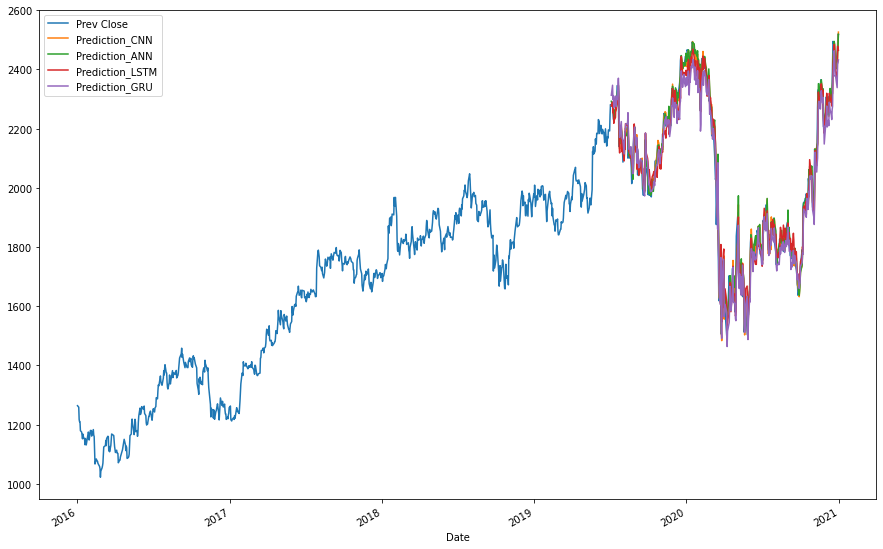

In [403]:
df[[ 'Prev Close','Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10));

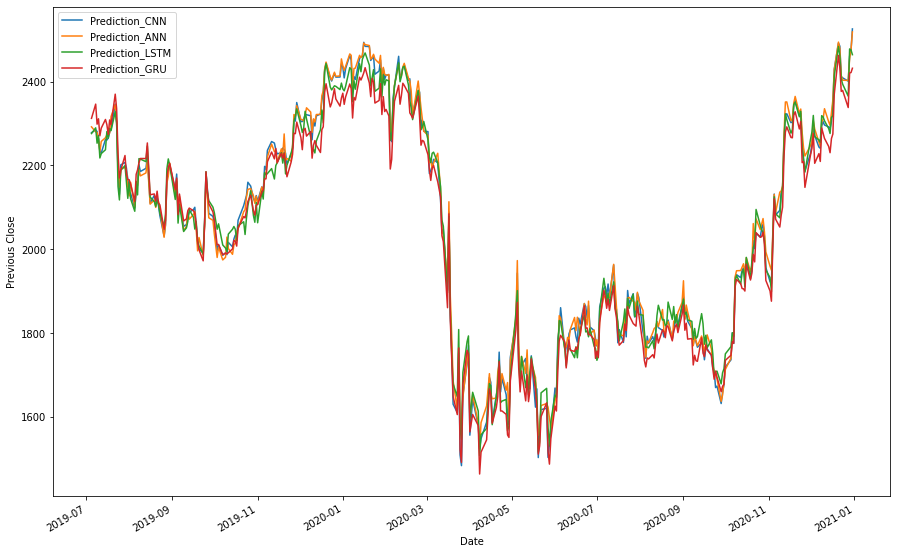

In [404]:
df[[ 'Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10),
    ylabel=("Previous Close"));

Evaluation

In [405]:
pred_ann=df['Prediction_ANN']
pred_ann.dropna(inplace=True)

In [406]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_ann))
print(rmse)

53.54080329388594


In [407]:
error=mean_absolute_error(test['Prev Close'],pred_ann)
print(error)

37.44351319375868


In [408]:
r2_score(test['Prev Close'],pred_ann)

0.9607451570389078

In [409]:
pred_cnn=df['Prediction_CNN']
pred_cnn.dropna(inplace=True)

In [410]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_cnn))
print(rmse)

52.41762704023658


In [411]:
error=mean_absolute_error(test['Prev Close'],pred_cnn)
print(error)

36.0242312759638


In [412]:
r2_score(test['Prev Close'],pred_cnn)

0.9623748541951915

In [413]:
pred_lstm=df['Prediction_LSTM']
pred_lstm.dropna(inplace=True)

In [414]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm))
print(rmse)

57.34736806366756


In [415]:
error=mean_absolute_error(test['Prev Close'],pred_lstm)
print(error)

42.333941779773674


In [416]:
r2_score(test['Prev Close'],pred_lstm)

0.9549649695690915

In [417]:
pred_gru=df['Prediction_GRU']
pred_gru.dropna(inplace=True)

In [418]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_gru))
print(rmse)

63.0149948551557


In [419]:
error=mean_absolute_error(test['Prev Close'],pred_gru)
print(error)

47.831470987706815


In [420]:
r2_score(test['Prev Close'],pred_gru)

0.9456234951597993